In [354]:
import pandas as pd
import numpy as np
import math


In [355]:
from PIL import Image
from io import BytesIO

In [356]:
import matplotlib.pyplot as plt

In [357]:
def log_sum_exp(Z):
    '''
    Compute log(\sum_i exp(Z_i)) for some array Z.
    ''' 
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z)))) 

In [358]:
def loglikelihood(data, weights, means, covs):
    '''
    Compute the loglikelihood of the data for a Guassian mixture model with 
    the given parameters
    '''
    
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        Z = np.zeros(num_clusters)
        
        for k in range(num_clusters):
            # Compute (x - mu)^T * sigma^{-1} * (x - mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point
            # and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi)
                            + np.log(np.linalg.det(covs[k])) + exponent_term)
        
        # Increment loglihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
    
    return ll
    

## E-step: assign cluster responsibilities given current parameters

In [359]:
from scipy.stats import multivariate_normal

In [360]:
def compute_responsibilities(data, weights, means, covariances):
    '''
    E-step: compute responsibilities, given the current parameters
    '''
    num_data = len(data)
    num_clusters = len(means)
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i, k] is the responsiblity of cluster k
    # for data point i.
    # Hint: To compute likelihood of seeing data point i given cluster k, use 
    # multivariate_normal.pdf
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] = weights[k] * multivariate_normal.pdf(data[i], 
                                                          mean=means[k],
                                                          cov=covariances[k]
                                                         )
    # App up responsiblities over each data point and normalize
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    return resp

## Checkpoint

In [361]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

print (resp)
print ('---')
if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print ('Checkpoint passed!')
else:
    print ('Check your code again.')

[[0.10512733 0.89487267]
 [0.46468164 0.53531836]]
---
Checkpoint passed!


## M-step: Update parameters, given current cluster responsibilities

### Computing soft counts

In [362]:
def compute_soft_counts(resp):
    # Compute the total responsibility assigned to each cluster,
    # which will be useful when implementing M-steps below.
    # In the lectures, this is called N^{soft}
    return resp.sum(axis=0)

### Update weights

In [363]:
def compute_weights(counts):
    num_clusters = len(counts)
    weights = [0.] * num_clusters
    total_point = sum(counts)
    
    for k in range(num_clusters):
        # Update the weight for cluster k using the M-step update rule for
        # the cluster weight, \hat{\pi}_k
        # HINT: compute # of data points by summing soft counts.
        weights[k] = counts[k] / total_point
    
    return weights

### Checkpoint

In [364]:
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)

print (counts)
print (weights)

if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print ('Checkpoint passed!')
else:
    print ('Check your code again.')

[0.83714598 2.16285402]
[0.27904865942515705, 0.720951340574843]
Checkpoint passed!


## Updating means

In [365]:
def compute_means(data, resp, counts):
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):
        # Update means for cluster k using the M-step update rule for
        # the mean variables.
        # THis will assign the variable means[k] to be our estimate for 
        # \hat{\mu}_k
        
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += resp[i, k] * data[i]
            
        # Vectorize
#         weighted_sum = resp[:, k]
        means[k] = weighted_sum / counts[k]
    
    return means

In [366]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print ('Checkpoint passed!')
else:
    print ('Check your code again.')

Checkpoint passed!


## Updating covariances

In [367]:
np.outer?

In [368]:
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim, num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule
        # for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for
        # \hat{\Sigma}_k
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            # HINT: use np.outer on the data[i] and this cluster's mean
            diff = data[i] - means[k]
            weighted_sum += resp[i, k] * np.outer(diff, diff)
        
        covariances[k] = weighted_sum / counts[k]
    
    return covariances

### Checkpoint

In [369]:
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print ('Checkpoint passed!')
else:
    print ('Check your code again.')

Checkpoint passed!


## The EM algorithm

In [370]:
def EM(data, init_means, init_covariances, init_weights,
       maxiter=1000, thresh=1e-4):
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print ("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)
        
        # M-step:
        # Compute the total responsiblitiy assigned to each cluster, which 
        # will be useful when implementing M-steps below. In the lectures is call
        # N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the
        # cluster weight, \hat{\pi}_k
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean 
        # variables.
        # This will assign the variable means[k] to be our estimate
        # for \hat{\mu}_k
        means = compute_means(data, resp, counts)
        
        # Update covariacnces for cluster k using ....
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        
        ll = ll_latest
    
    if (it % 5 != 0):
        print ("Iteration %s" % it)
        
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out
    
    
        
        

## Testing the implementation on the simulated data

In [371]:
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [372]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

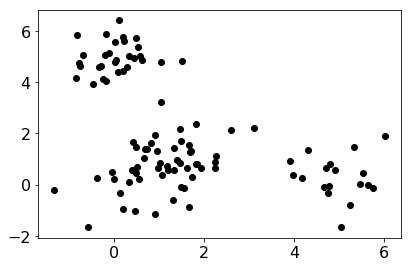

In [373]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [374]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3

# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


In [375]:
results

{'weights': [0.3007102300609824, 0.17993710074247016, 0.5193526691965474],
 'means': [array([0.02138285, 4.947729  ]),
  array([4.94239235, 0.31365311]),
  array([1.08181125, 0.73903508])],
 'covs': [array([[0.2932614 , 0.05048455],
         [0.05048455, 0.35281537]]), array([[ 0.3556437 , -0.01494875],
         [-0.01494875,  0.66695025]]), array([[0.67114992, 0.33058965],
         [0.33058965, 0.90429724]])],
 'loglik': [-541.3161248036661,
  -372.1355927865928,
  -366.99356972063583,
  -365.65991992885023,
  -364.33486476974326,
  -362.87960460172394,
  -361.37504027778317,
  -359.7842225540678,
  -357.83486581694126,
  -354.4429407838179,
  -347.33757513783434,
  -338.9500319134904,
  -336.1926973689691,
  -333.81303185903346,
  -329.78761702083597,
  -323.1580854903376,
  -319.52041347639164,
  -319.1101542516828,
  -318.91107575136516,
  -318.8437574328325,
  -318.8321411837265,
  -318.83092993526367,
  -318.830829251483,
  -318.83082148560914],
 'resp': array([[9.99999759e-01, 8

## Quiz Question: What is the weight that EM assigns to the first component after running the above code block?



In [376]:
results['weights'][0]

0.3007102300609824

## Quiz Question: Using the same set of results, obtain the mean that EM assigns the second component. What is the mean in the first dimension?



In [377]:
results['means']

[array([0.02138285, 4.947729  ]),
 array([4.94239235, 0.31365311]),
 array([1.08181125, 0.73903508])]

In [378]:
results['means'][1][0]

4.9423923529753555

## Quiz Question: Using the same set of results, obtain the covariance that EM assigns the third component. What is the variance in the first dimension?



In [379]:
results['covs']

[array([[0.2932614 , 0.05048455],
        [0.05048455, 0.35281537]]), array([[ 0.3556437 , -0.01494875],
        [-0.01494875,  0.66695025]]), array([[0.67114992, 0.33058965],
        [0.33058965, 0.90429724]])]

In [380]:
results['covs'][2]

array([[0.67114992, 0.33058965],
       [0.33058965, 0.90429724]])

## Plot progress of parameters

In [381]:
import matplotlib.mlab as mlab

In [382]:
%matplotlib inline

In [383]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data], 'ko') # data
    
    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1] / (sigmax * sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

/Users/tdx/anaconda2/envs/ds-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.


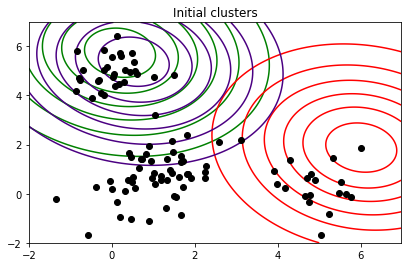

In [384]:
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

Iteration 0
Iteration 5
Iteration 10
Iteration 11


/Users/tdx/anaconda2/envs/ds-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in Matplotlib 2.2 and will be removed in 3.1.


Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


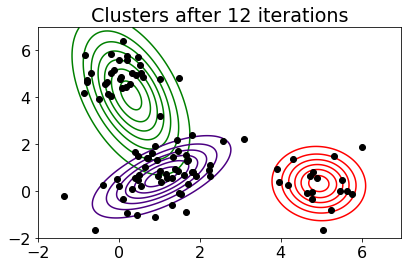

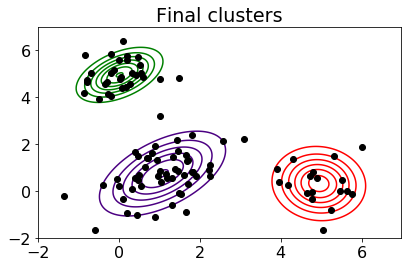

In [385]:
# Parameters after 12 iterations
results = EM(data, initial_means, initial_covs, initial_weights, maxiter=12)
plot_contours(data, results['means'], results['covs'], 'Clusters after 12 iterations')

# Parameters after running EM to convergence
results = EM(data, initial_means, initial_covs, initial_weights)
plot_contours(data, results['means'], results['covs'], 'Final clusters')

### Quiz Question: Plot the loglikelihood that is observed at each iteration. Is the loglikelihood plot monotonically increasing, monotonically decreasing, or neither [multiple choice]? Complete the following code block to answer the question.



Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


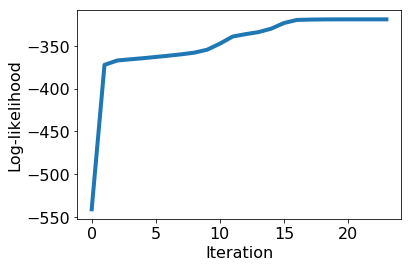

In [386]:
results = EM(data, initial_means, initial_covs, initial_weights)

# YOUR CODE HERE
loglikelihoods = results['loglik']

plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Fitting a Gaussian mixture model for image data


In [387]:
%ls

3_em-for-gmm_blank.ipynb
Implement EM for Gaussian mixtures.ipynb
_8a352ed8c119f98f079305de3bd46e26_images.zip
_a1fd39587bbfe4e686cae5cfb37f2c1c_chosen_images.png
images/


In [388]:
import pathlib
import imageio

In [389]:
%ls

3_em-for-gmm_blank.ipynb
Implement EM for Gaussian mixtures.ipynb
_8a352ed8c119f98f079305de3bd46e26_images.zip
_a1fd39587bbfe4e686cae5cfb37f2c1c_chosen_images.png
images/


In [390]:
%ls images/rivers

ANd9GcQ-9q7fjHdCPVLZHzTvLPvtklacP7xAO82eCTM2EuOxEL4Sl3qpzg.jpg
ANd9GcQ-Y4lf0VySCfoago7CrpHOCl1LHcbHaB2BMf6UvUSkeV4dtoIKlA.jpg
ANd9GcQ0VAnOVSM7Jt0rWfQAbKAzpmjhY_NRc4Wnsf8VsOG8HSB-dgYi.jpg
ANd9GcQ0W4zSfC1L5XbzSup3sflvvu10z4CDiheIA39HHvAd6ZgcOmaTkQ.jpg
ANd9GcQ0XNnCueBMO1yMQbMIEjA9yy0dnDGTCa1N1LQ-eyscY_louA-HuQ.jpg
ANd9GcQ0p0VhR7dXlGVaCDrmjPiWolZXDzA9882JcLja6au0zCpRZLdv.jpg
ANd9GcQ155gIdV-BHQ1aUxoTX32O2VFtJhHrYB-h5X1x4LjsMiqJR53LGQ.jpg
ANd9GcQ1O55e0PJcYuSLDZMyl0sP2fja4OJWp09Z2l4mUK4s4LbZlx3F.jpg
ANd9GcQ1hvqTjojWKvUcifxEkFYwd20YJ370RpChBgdKQkZQoZdwf7B1dw.jpg
ANd9GcQ3-U1iFeTeromrkQz-Wl_oCKdNZX_JE_57_wDHEcy2fVCPpPwuMg.jpg
ANd9GcQ34EpqQbnJHZIzsaWOFUJmvFSl88oolAQlaBUoHtVV4M3Nw0IDJw.jpg
ANd9GcQ36m9IkUgJyixD-5UKPTE2FOA3EmG4jnC1_Gk2tAbVyB8DgyOw.jpg
ANd9GcQ3whYfUGrHELoCiurYMmOps_dNp0p2mIMPcV7PVMJM2Vl9zkvodw.jpg
ANd9GcQ42LTPJRt5lRQc6SDm-jXxBRtqLFEN1hQTNfpeviZQ3s7JUemI1g.jpg
ANd9GcQ4HmanLwwYpoDvuMV2gZ-hPHUKe_pEfASta1XhcQsdwAvYzEN-.jpg
ANd9GcQ4JP-7ZLgGwC2qrsx_Z5a-plNug0qhp3N9IRDo6sshcLyfxzWO6w.jpg
AN

In [391]:
paths = pathlib.Path('images').glob('*/*.jpg')

In [392]:
all_paths = []

for path in paths:
    all_paths += [str(path)]

In [393]:
all_paths[0][0:8]

'images/t'

In [394]:
all_paths = sorted(all_paths, key=lambda u: u[0:8])

In [395]:
all_paths

['images/cloudy_sky/ANd9GcR-ItBmuGUW0V_RN1QOc5R1SQg1FnAjwMsZGZFFiRe4T4vnju2k.jpg',
 'images/cloudy_sky/ANd9GcTjzu_EqTTfdptUUBIuddb418wOhWl8AmaYqWzrvZ4rLdeODc3yMA.jpg',
 'images/cloudy_sky/ANd9GcSvFSM-pfrRtxXkUiyDbkfgBgIi5nRIwCcsYXyoAtWSLGK5vEEs.jpg',
 'images/cloudy_sky/ANd9GcTrRP_8QOzL8SuTRpY_S1S7RLJay1RE0lS7yIBqN0O2A9NwUktYpg.jpg',
 'images/cloudy_sky/ANd9GcSmJf46Ko3nRIUKv_o9tY204dv9WDwGs659D8l8tFffkNBsLHpw.jpg',
 'images/cloudy_sky/ANd9GcSLbazJoP_1IR9tHkREp0Ra90pgk9B3Czt12NUN0cSofkk0nJaf.jpg',
 'images/cloudy_sky/ANd9GcQ1D4YUCLe5MCG4xd5iNJGh2f84w-oayS1Gwo4x_hWGthcKB3X9.jpg',
 'images/cloudy_sky/ANd9GcQ0sa93MklyNXW_oukodvV0P1-Wyl_bpOLmibpxxbYEkkl4_2Mc.jpg',
 'images/cloudy_sky/ANd9GcQgQ-VQAuMOUKMf0EjIdR8zSrgr9pTWUkJdx5-YoD7p4UAm24Us.jpg',
 'images/cloudy_sky/ANd9GcRoiTdeKWZawX58aVdis_jclewv1VERkbbPhAQ0jUcjH_Uj2FFbww.jpg',
 'images/cloudy_sky/ANd9GcTtUbQ7FRfFRLZ6I9bQElBVx7MYfx6a3rPLcrUrGSPwzY40wP9tiA.jpg',
 'images/cloudy_sky/ANd9GcSSimRraWZAci1YTbOys6Qf2DOJn1v2yW3iBa-fLT-AB3ksqADhWw.

In [396]:
all_paths

['images/cloudy_sky/ANd9GcR-ItBmuGUW0V_RN1QOc5R1SQg1FnAjwMsZGZFFiRe4T4vnju2k.jpg',
 'images/cloudy_sky/ANd9GcTjzu_EqTTfdptUUBIuddb418wOhWl8AmaYqWzrvZ4rLdeODc3yMA.jpg',
 'images/cloudy_sky/ANd9GcSvFSM-pfrRtxXkUiyDbkfgBgIi5nRIwCcsYXyoAtWSLGK5vEEs.jpg',
 'images/cloudy_sky/ANd9GcTrRP_8QOzL8SuTRpY_S1S7RLJay1RE0lS7yIBqN0O2A9NwUktYpg.jpg',
 'images/cloudy_sky/ANd9GcSmJf46Ko3nRIUKv_o9tY204dv9WDwGs659D8l8tFffkNBsLHpw.jpg',
 'images/cloudy_sky/ANd9GcSLbazJoP_1IR9tHkREp0Ra90pgk9B3Czt12NUN0cSofkk0nJaf.jpg',
 'images/cloudy_sky/ANd9GcQ1D4YUCLe5MCG4xd5iNJGh2f84w-oayS1Gwo4x_hWGthcKB3X9.jpg',
 'images/cloudy_sky/ANd9GcQ0sa93MklyNXW_oukodvV0P1-Wyl_bpOLmibpxxbYEkkl4_2Mc.jpg',
 'images/cloudy_sky/ANd9GcQgQ-VQAuMOUKMf0EjIdR8zSrgr9pTWUkJdx5-YoD7p4UAm24Us.jpg',
 'images/cloudy_sky/ANd9GcRoiTdeKWZawX58aVdis_jclewv1VERkbbPhAQ0jUcjH_Uj2FFbww.jpg',
 'images/cloudy_sky/ANd9GcTtUbQ7FRfFRLZ6I9bQElBVx7MYfx6a3rPLcrUrGSPwzY40wP9tiA.jpg',
 'images/cloudy_sky/ANd9GcSSimRraWZAci1YTbOys6Qf2DOJn1v2yW3iBa-fLT-AB3ksqADhWw.

In [397]:
im = imageio.imread(str(all_paths[0]))

In [398]:
images = pd.DataFrame({'red': [], 'green': [], 'blue': [], 'rgb': [],
                       'path': []
                      })
max_iter = 3
iter = 0

for path in all_paths:
    
    image = imageio.imread(path)
    r = np.mean(image[:, :, 0]/256.0)
    g = np.mean(image[:, :, 1]/256.0)
    b = np.mean(image[:, :, 2]/256.0)
    images = images.append({'red': r, 'green': g, 'blue': b, 'rgb': [r,g,b],
                            'path': path 
                           },
                          ignore_index=True)
    
    iter += 1
    if iter % 10 == 0:
        print ("processed %d out of %d" % (iter, len(all_paths))) 

processed 10 out of 1328
processed 20 out of 1328
processed 30 out of 1328
processed 40 out of 1328
processed 50 out of 1328
processed 60 out of 1328
processed 70 out of 1328
processed 80 out of 1328
processed 90 out of 1328
processed 100 out of 1328
processed 110 out of 1328
processed 120 out of 1328
processed 130 out of 1328
processed 140 out of 1328
processed 150 out of 1328
processed 160 out of 1328
processed 170 out of 1328
processed 180 out of 1328
processed 190 out of 1328
processed 200 out of 1328
processed 210 out of 1328
processed 220 out of 1328
processed 230 out of 1328
processed 240 out of 1328
processed 250 out of 1328
processed 260 out of 1328
processed 270 out of 1328
processed 280 out of 1328
processed 290 out of 1328
processed 300 out of 1328
processed 310 out of 1328
processed 320 out of 1328
processed 330 out of 1328
processed 340 out of 1328
processed 350 out of 1328
processed 360 out of 1328
processed 370 out of 1328
processed 380 out of 1328
processed 390 out of 

In [399]:
images.head(n=3)

red     green      blue  \
0  0.566793  0.566793  0.566793   
1  0.536150  0.513922  0.451710   
2  0.415036  0.434442  0.431181   

                                                 rgb  \
0  [0.5667928634866457, 0.5667928634866457, 0.566...   
1  [0.5361503685059793, 0.5139224541161797, 0.451...   
2  [0.41503583618596507, 0.434442153977431, 0.431...   

                                                path  
0  images/cloudy_sky/ANd9GcR-ItBmuGUW0V_RN1QOc5R1...  
1  images/cloudy_sky/ANd9GcTjzu_EqTTfdptUUBIuddb4...  
2  images/cloudy_sky/ANd9GcSvFSM-pfrRtxXkUiyDbkfg...

## Initialization

In [400]:
images

red     green      blue  \
0     0.566793  0.566793  0.566793   
1     0.536150  0.513922  0.451710   
2     0.415036  0.434442  0.431181   
3     0.625088  0.610955  0.580739   
4     0.381515  0.537281  0.729517   
5     0.474803  0.475904  0.499002   
6     0.439874  0.471199  0.498986   
7     0.529008  0.541079  0.543306   
8     0.660184  0.680039  0.534360   
9     0.378542  0.377083  0.382692   
10    0.511775  0.633330  0.776593   
11    0.703959  0.832166  0.882307   
12    0.666775  0.715910  0.769604   
13    0.456007  0.480230  0.542033   
14    0.435791  0.489025  0.544528   
15    0.598083  0.606234  0.580382   
16    0.511435  0.610877  0.717586   
17    0.470731  0.612368  0.767139   
18    0.460464  0.726287  0.768421   
19    0.215644  0.289018  0.331414   
20    0.488742  0.528282  0.587709   
21    0.685696  0.715809  0.735800   
22    0.493791  0.500493  0.543725   
23    0.647885  0.693133  0.724486   
24    0.633897  0.638949  0.643582   
25    0.477332  0.542949  0.463894   
26    0.352536  0.410315  0.503642   
27    0.447617  0.539971  0.648000   
28    0.384701  0.445077  0.397677   
29    0.387854  0.386580  0.376899   
...        ...       ...       ...   
1298  0.552098  0.358779  0.139773   
1299  0.323426  0.347561  0.303118   
1300  0.512971  0.486910  0.468037   
1301  0.280172  0.387322  0.149967   
1302  0.481829  0.434199  0.406870   
1303  0.418651  0.428719  0.311562   
1304  0.283450  0.379094  0.371258   
1305  0.520633  0.545566  0.245967   
1306  0.448069  0.227819  0.133120   
1307  0.153117  0.164996  0.135533   
1308  0.442187  0.451619  0.458083   
1309  0.634309  0.602297  0.365966   
1310  0.288603  0.288646  0.244985   
1311  0.477104  0.329296  0.188987   
1312  0.303773  0.316631  0.201331   
1313  0.461089  0.515201  0.179367   
1314  0.422583  0.396925  0.297107   
1315  0.646173  0.616264  0.601576   
1316  0.276421  0.312585  0.282040   
1317  0.434351  0.461589  0.307317   
1318  0.312760  0.340055  0.388675   
1319  0.328303  0.268350  0.232522   
1320  0.499243  0.552127  0.523421   
1321  0.257871  0.234115  0.197956   
1322  0.281750  0.443098  0.296216   
1323  0.265425  0.324824  0.171170   
1324  0.439919  0.560188  0.381079   
1325  0.167590  0.279092  0.278355   
1326  0.463901  0.456811  0.373760   
1327  0.480103  0.516961  0.217840   

                                                    rgb  \
0     [0.5667928634866457, 0.5667928634866457, 0.566...   
1     [0.5361503685059793, 0.5139224541161797, 0.451...   
2     [0.41503583618596507, 0.434442153977431, 0.431...   
3     [0.6250880893868298, 0.6109552725558327, 0.580...   
4     [0.3815150669642857, 0.537280505952381, 0.7295...   
5     [0.47480293002966234, 0.4759036819159102, 0.49...   
6     [0.4398736342196394, 0.47119888896628587, 0.49...   
7     [0.5290081393294989, 0.5410785964305617, 0.543...   
8     [0.6601842592592593, 0.6800388888888889, 0.534...   
9     [0.3785417153853043, 0.3770825662739323, 0.382...   
10    [0.5117748555243893, 0.6333298053682264, 0.776...   
11    [0.7039592782684809, 0.8321663073426434, 0.882...   
12    [0.6667747346253768, 0.715910330398223, 0.7696...   
13    [0.4560074589270788, 0.4802298472764001, 0.542...   
14    [0.43579122373376944, 0.4890247113192586, 0.54...   
15    [0.5980829786201887, 0.606233503040043, 0.5803...   
16    [0.5114345219431836, 0.6108774816103281, 0.717...   
17    [0.4707314232724993, 0.6123681642568563, 0.767...   
18    [0.46046441075833533, 0.7262873342633485, 0.76...   
19    [0.21564401701440636, 0.2890175577496274, 0.33...   
20    [0.4887416169895678, 0.5282823366865375, 0.587...   
21    [0.6856957519006488, 0.7158092341927715, 0.735...   
22    [0.49379084511408733, 0.5004931640625, 0.54372...   
23    [0.6478852905418817, 0.693133125744343, 0.7244...   
24    [0.6338967803030303, 0.6389487083954297, 0.643...   
25    [0.4773315613368179, 0.5429494925308862, 0.463...   
26    [0.3525363803835131, 0.4103152334265414, 0.503...   
27

In [401]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  

# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45
Iteration 50
Iteration 55
Iteration 60
Iteration 65
Iteration 70
Iteration 75
Iteration 80
Iteration 85
Iteration 90
Iteration 95
Iteration 100
Iteration 105
Iteration 110
Iteration 115
Iteration 120
Iteration 125
Iteration 130
Iteration 135
Iteration 140
Iteration 145
Iteration 149


## Evaluating convergence

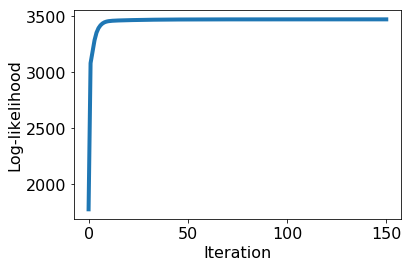

In [402]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

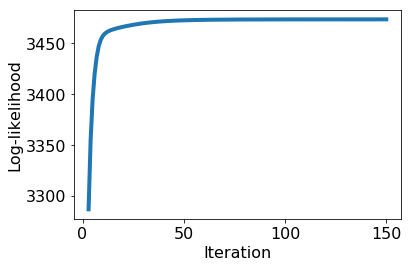

In [403]:
plt.figure()
plt.plot(range(3,len(ll)),ll[3:],linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Evaluating uncertainty

In [404]:
import colorsys
def plot_responsibilities_in_RB(img, resp, title):
    N, K = resp.shape
    
    HSV_tuples = [(x*1.0/K, 0.5, 0.9) for x in range(K)]
    RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
    
    R = img['red']
    B = img['blue']
    resp_by_img_int = [[resp[n][k] for k in range(K)] for n in range(N)]
    cols = [(np.dot(resp_by_img_int[n], np.array(RGB_tuples))) for n in range(int(N))]

    plt.figure()
    for n in range(len(R)):
        plt.plot(R[n], B[n], 'o', c=cols[n])
    plt.title(title)
    plt.xlabel('R value')
    plt.ylabel('B value')
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

In [405]:
images_bk = images[:]

In [406]:
#images.drop(['rgb'], axis=1, inplace=True, errors='ignore')

In [407]:
#images.head()

In [408]:
# random responsiblities

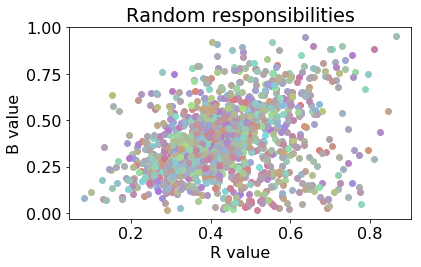

In [409]:
N, K = out['resp'].shape
random_resp = np.random.dirichlet(np.ones(K), N)
plot_responsibilities_in_RB(images, random_resp, 'Random responsibilities')

In [410]:
# 1 iteration

Iteration 0


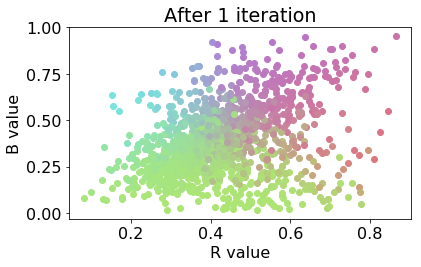

In [411]:
out_1 = EM(img_data, init_means, init_covariances, init_weights, maxiter=1)
plot_responsibilities_in_RB(images, out_1['resp'], 'After 1 iteration')

In [412]:
# 20 iterations

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 19


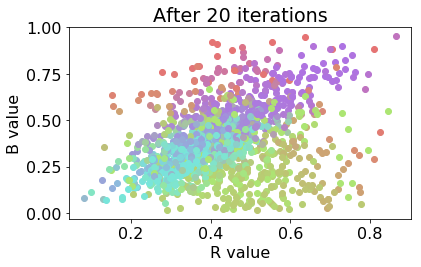

In [413]:
out_20 = EM(img_data, init_means, init_covariances, init_weights, maxiter=20)
plot_responsibilities_in_RB(images, out_20['resp'], 'After 20 iterations')

In [414]:
# Interpreting each cluster

In [441]:
out_20

{'weights': [0.12800517547581314,
  0.303107123147304,
  0.30744494796051436,
  0.2614427534163684],
 'means': [array([0.48265474, 0.48440347, 0.48285305]),
  array([0.45032855, 0.35342415, 0.28943976]),
  array([0.36520237, 0.40339347, 0.33471442]),
  array([0.4612416 , 0.49758414, 0.52499314])],
 'covs': [array([[ 0.02024934,  0.00780629, -0.0045719 ],
         [ 0.00780629,  0.02264227,  0.02875794],
         [-0.0045719 ,  0.02875794,  0.05511762]]),
  array([[ 0.0169278 ,  0.00305306, -0.00010992],
         [ 0.00305306,  0.01431319,  0.0094734 ],
         [-0.00010992,  0.0094734 ,  0.02278965]]),
  array([[0.00759802, 0.00715239, 0.00673976],
         [0.00715239, 0.00837485, 0.00767053],
         [0.00673976, 0.00767053, 0.01211793]]),
  array([[0.01474275, 0.01409384, 0.01417494],
         [0.01409384, 0.01567121, 0.01806135],
         [0.01417494, 0.01806135, 0.02370217]])],
 'loglik': [1774.579293684049,
  3081.6052472536294,
  3186.56738223554,
  3286.564880546623,
  3354.3

In [415]:
out

{'weights': [0.24712368955315722,
  0.16424894890290817,
  0.2961421071828493,
  0.2924852543610854],
 'means': [array([0.4753523 , 0.41047038, 0.37653117]),
  array([0.45341879, 0.36607464, 0.32386316]),
  array([0.35980287, 0.40171973, 0.31871845]),
  array([0.45353   , 0.48792929, 0.50966994])],
 'covs': [array([[ 0.01710397,  0.00532867, -0.00542731],
         [ 0.00532867,  0.02313132,  0.02907163],
         [-0.00542731,  0.02907163,  0.05252187]]),
  array([[0.01746487, 0.00366251, 0.00316583],
         [0.00366251, 0.01526619, 0.00730244],
         [0.00316583, 0.00730244, 0.02163413]]),
  array([[0.00739436, 0.00675315, 0.00595055],
         [0.00675315, 0.00809797, 0.00674558],
         [0.00595055, 0.00674558, 0.01122966]]),
  array([[0.01516239, 0.01485599, 0.01548339],
         [0.01485599, 0.0166539 , 0.01943925],
         [0.01548339, 0.01943925, 0.02544804]])],
 'loglik': [1774.579293684049,
  3081.6052472536294,
  3186.56738223554,
  3286.564880546623,
  3354.305506146

## Quiz question: Calculate the likelihood (score) of the first image in our data set (images[0]) under each Gaussian component through a call to multivariate_normal.pdf. Given these values, what cluster assignment should we make for this image? 
Hint: don't forget to use the cluster weights.

In [416]:
weights = out['weights']
means = out['means']
covariances = out['covs']

In [417]:
images

red     green      blue  \
0     0.566793  0.566793  0.566793   
1     0.536150  0.513922  0.451710   
2     0.415036  0.434442  0.431181   
3     0.625088  0.610955  0.580739   
4     0.381515  0.537281  0.729517   
5     0.474803  0.475904  0.499002   
6     0.439874  0.471199  0.498986   
7     0.529008  0.541079  0.543306   
8     0.660184  0.680039  0.534360   
9     0.378542  0.377083  0.382692   
10    0.511775  0.633330  0.776593   
11    0.703959  0.832166  0.882307   
12    0.666775  0.715910  0.769604   
13    0.456007  0.480230  0.542033   
14    0.435791  0.489025  0.544528   
15    0.598083  0.606234  0.580382   
16    0.511435  0.610877  0.717586   
17    0.470731  0.612368  0.767139   
18    0.460464  0.726287  0.768421   
19    0.215644  0.289018  0.331414   
20    0.488742  0.528282  0.587709   
21    0.685696  0.715809  0.735800   
22    0.493791  0.500493  0.543725   
23    0.647885  0.693133  0.724486   
24    0.633897  0.638949  0.643582   
25    0.477332  0.542949  0.463894   
26    0.352536  0.410315  0.503642   
27    0.447617  0.539971  0.648000   
28    0.384701  0.445077  0.397677   
29    0.387854  0.386580  0.376899   
...        ...       ...       ...   
1298  0.552098  0.358779  0.139773   
1299  0.323426  0.347561  0.303118   
1300  0.512971  0.486910  0.468037   
1301  0.280172  0.387322  0.149967   
1302  0.481829  0.434199  0.406870   
1303  0.418651  0.428719  0.311562   
1304  0.283450  0.379094  0.371258   
1305  0.520633  0.545566  0.245967   
1306  0.448069  0.227819  0.133120   
1307  0.153117  0.164996  0.135533   
1308  0.442187  0.451619  0.458083   
1309  0.634309  0.602297  0.365966   
1310  0.288603  0.288646  0.244985   
1311  0.477104  0.329296  0.188987   
1312  0.303773  0.316631  0.201331   
1313  0.461089  0.515201  0.179367   
1314  0.422583  0.396925  0.297107   
1315  0.646173  0.616264  0.601576   
1316  0.276421  0.312585  0.282040   
1317  0.434351  0.461589  0.307317   
1318  0.312760  0.340055  0.388675   
1319  0.328303  0.268350  0.232522   
1320  0.499243  0.552127  0.523421   
1321  0.257871  0.234115  0.197956   
1322  0.281750  0.443098  0.296216   
1323  0.265425  0.324824  0.171170   
1324  0.439919  0.560188  0.381079   
1325  0.167590  0.279092  0.278355   
1326  0.463901  0.456811  0.373760   
1327  0.480103  0.516961  0.217840   

                                                    rgb  \
0     [0.5667928634866457, 0.5667928634866457, 0.566...   
1     [0.5361503685059793, 0.5139224541161797, 0.451...   
2     [0.41503583618596507, 0.434442153977431, 0.431...   
3     [0.6250880893868298, 0.6109552725558327, 0.580...   
4     [0.3815150669642857, 0.537280505952381, 0.7295...   
5     [0.47480293002966234, 0.4759036819159102, 0.49...   
6     [0.4398736342196394, 0.47119888896628587, 0.49...   
7     [0.5290081393294989, 0.5410785964305617, 0.543...   
8     [0.6601842592592593, 0.6800388888888889, 0.534...   
9     [0.3785417153853043, 0.3770825662739323, 0.382...   
10    [0.5117748555243893, 0.6333298053682264, 0.776...   
11    [0.7039592782684809, 0.8321663073426434, 0.882...   
12    [0.6667747346253768, 0.715910330398223, 0.7696...   
13    [0.4560074589270788, 0.4802298472764001, 0.542...   
14    [0.43579122373376944, 0.4890247113192586, 0.54...   
15    [0.5980829786201887, 0.606233503040043, 0.5803...   
16    [0.5114345219431836, 0.6108774816103281, 0.717...   
17    [0.4707314232724993, 0.6123681642568563, 0.767...   
18    [0.46046441075833533, 0.7262873342633485, 0.76...   
19    [0.21564401701440636, 0.2890175577496274, 0.33...   
20    [0.4887416169895678, 0.5282823366865375, 0.587...   
21    [0.6856957519006488, 0.7158092341927715, 0.735...   
22    [0.49379084511408733, 0.5004931640625, 0.54372...   
23    [0.6478852905418817, 0.693133125744343, 0.7244...   
24    [0.6338967803030303, 0.6389487083954297, 0.643...   
25    [0.4773315613368179, 0.5429494925308862, 0.463...   
26    [0.3525363803835131, 0.4103152334265414, 0.503...   
27

In [418]:
first_image = images.iloc[0]['rgb']

In [442]:
images

red     green      blue  \
0     0.566793  0.566793  0.566793   
1     0.536150  0.513922  0.451710   
2     0.415036  0.434442  0.431181   
3     0.625088  0.610955  0.580739   
4     0.381515  0.537281  0.729517   
5     0.474803  0.475904  0.499002   
6     0.439874  0.471199  0.498986   
7     0.529008  0.541079  0.543306   
8     0.660184  0.680039  0.534360   
9     0.378542  0.377083  0.382692   
10    0.511775  0.633330  0.776593   
11    0.703959  0.832166  0.882307   
12    0.666775  0.715910  0.769604   
13    0.456007  0.480230  0.542033   
14    0.435791  0.489025  0.544528   
15    0.598083  0.606234  0.580382   
16    0.511435  0.610877  0.717586   
17    0.470731  0.612368  0.767139   
18    0.460464  0.726287  0.768421   
19    0.215644  0.289018  0.331414   
20    0.488742  0.528282  0.587709   
21    0.685696  0.715809  0.735800   
22    0.493791  0.500493  0.543725   
23    0.647885  0.693133  0.724486   
24    0.633897  0.638949  0.643582   
25    0.477332  0.542949  0.463894   
26    0.352536  0.410315  0.503642   
27    0.447617  0.539971  0.648000   
28    0.384701  0.445077  0.397677   
29    0.387854  0.386580  0.376899   
...        ...       ...       ...   
1298  0.552098  0.358779  0.139773   
1299  0.323426  0.347561  0.303118   
1300  0.512971  0.486910  0.468037   
1301  0.280172  0.387322  0.149967   
1302  0.481829  0.434199  0.406870   
1303  0.418651  0.428719  0.311562   
1304  0.283450  0.379094  0.371258   
1305  0.520633  0.545566  0.245967   
1306  0.448069  0.227819  0.133120   
1307  0.153117  0.164996  0.135533   
1308  0.442187  0.451619  0.458083   
1309  0.634309  0.602297  0.365966   
1310  0.288603  0.288646  0.244985   
1311  0.477104  0.329296  0.188987   
1312  0.303773  0.316631  0.201331   
1313  0.461089  0.515201  0.179367   
1314  0.422583  0.396925  0.297107   
1315  0.646173  0.616264  0.601576   
1316  0.276421  0.312585  0.282040   
1317  0.434351  0.461589  0.307317   
1318  0.312760  0.340055  0.388675   
1319  0.328303  0.268350  0.232522   
1320  0.499243  0.552127  0.523421   
1321  0.257871  0.234115  0.197956   
1322  0.281750  0.443098  0.296216   
1323  0.265425  0.324824  0.171170   
1324  0.439919  0.560188  0.381079   
1325  0.167590  0.279092  0.278355   
1326  0.463901  0.456811  0.373760   
1327  0.480103  0.516961  0.217840   

                                                    rgb  \
0     [0.5667928634866457, 0.5667928634866457, 0.566...   
1     [0.5361503685059793, 0.5139224541161797, 0.451...   
2     [0.41503583618596507, 0.434442153977431, 0.431...   
3     [0.6250880893868298, 0.6109552725558327, 0.580...   
4     [0.3815150669642857, 0.537280505952381, 0.7295...   
5     [0.47480293002966234, 0.4759036819159102, 0.49...   
6     [0.4398736342196394, 0.47119888896628587, 0.49...   
7     [0.5290081393294989, 0.5410785964305617, 0.543...   
8     [0.6601842592592593, 0.6800388888888889, 0.534...   
9     [0.3785417153853043, 0.3770825662739323, 0.382...   
10    [0.5117748555243893, 0.6333298053682264, 0.776...   
11    [0.7039592782684809, 0.8321663073426434, 0.882...   
12    [0.6667747346253768, 0.715910330398223, 0.7696...   
13    [0.4560074589270788, 0.4802298472764001, 0.542...   
14    [0.43579122373376944, 0.4890247113192586, 0.54...   
15    [0.5980829786201887, 0.606233503040043, 0.5803...   
16    [0.5114345219431836, 0.6108774816103281, 0.717...   
17    [0.4707314232724993, 0.6123681642568563, 0.767...   
18    [0.46046441075833533, 0.7262873342633485, 0.76...   
19    [0.21564401701440636, 0.2890175577496274, 0.33...   
20    [0.4887416169895678, 0.5282823366865375, 0.587...   
21    [0.6856957519006488, 0.7158092341927715, 0.735...   
22    [0.49379084511408733, 0.5004931640625, 0.54372...   
23    [0.6478852905418817, 0.693133125744343, 0.7244...   
24    [0.6338967803030303, 0.6389487083954297, 0.643...   
25    [0.4773315613368179, 0.5429494925308862, 0.463...   
26    [0.3525363803835131, 0.4103152334265414, 0.503...   
27

In [419]:
first_image

[0.5667928634866457, 0.5667928634866457, 0.5667928634866457]

In [420]:
p0 = out['weights'][0] * multivariate_normal.pdf(first_image,
                                                 mean=means[0],
                                                 cov=covariances[0]
                                                )

In [421]:
p1 = out['weights'][1] * multivariate_normal.pdf(first_image,
                                                 mean=means[1],
                                                 cov=covariances[1]
                                                )

In [422]:
p2 = out['weights'][2] * multivariate_normal.pdf(first_image,
                                                 mean=means[2],
                                                 cov=covariances[2]
                                                )

In [423]:
p3 = out['weights'][3] * multivariate_normal.pdf(first_image,
                                                 mean=means[3],
                                                 cov=covariances[3]
                                                )

In [424]:
len(means)

4

In [425]:
p0, p1, p2,p3

(4.850135862049306, 0.6592957582377177, 1.342566578498475, 53.36922301295646)

In [426]:
first_image

[0.5667928634866457, 0.5667928634866457, 0.5667928634866457]

In [427]:
images.head(4)

red     green      blue  \
0  0.566793  0.566793  0.566793   
1  0.536150  0.513922  0.451710   
2  0.415036  0.434442  0.431181   
3  0.625088  0.610955  0.580739   

                                                 rgb  \
0  [0.5667928634866457, 0.5667928634866457, 0.566...   
1  [0.5361503685059793, 0.5139224541161797, 0.451...   
2  [0.41503583618596507, 0.434442153977431, 0.431...   
3  [0.6250880893868298, 0.6109552725558327, 0.580...   

                                                path  
0  images/cloudy_sky/ANd9GcR-ItBmuGUW0V_RN1QOc5R1...  
1  images/cloudy_sky/ANd9GcTjzu_EqTTfdptUUBIuddb4...  
2  images/cloudy_sky/ANd9GcSvFSM-pfrRtxXkUiyDbkfg...  
3  images/cloudy_sky/ANd9GcTrRP_8QOzL8SuTRpY_S1S7...

In [428]:
N = len(images) # number of images
K = len(means) # number of clusters
rgb = images['rgb']
assignments = [0] * N
probs = [0.] * N

for i in range(N):
    # Compute the score of data point i under each Gaussian component
    p = np.zeros(K)
    for k in range(K):
        p[k] = weights[k] * multivariate_normal.pdf(rgb[i],
                                                    mean=means[k],
                                                    cov=covariances[k])
    
    # Compute assignments of each data point to a given cluster based on the 
    # above scores:
    assignments[i] = np.argmax(p)
    
    # For data point i, store the corresponding score under this cluster assignment
    probs[i] = np.max(p)

assignments = pd.DataFrame({'assignments': assignments, 
                            'probs': probs,
                            'path': images['path']
                           })

In [429]:
assignments.head(n=5)

assignments      probs                                               path
0            3  53.369223  images/cloudy_sky/ANd9GcR-ItBmuGUW0V_RN1QOc5R1...
1            3  25.437150  images/cloudy_sky/ANd9GcTjzu_EqTTfdptUUBIuddb4...
2            3  93.284781  images/cloudy_sky/ANd9GcSvFSM-pfrRtxXkUiyDbkfg...
3            3  22.976533  images/cloudy_sky/ANd9GcTrRP_8QOzL8SuTRpY_S1S7...
4            0   2.092669  images/cloudy_sky/ANd9GcSmJf46Ko3nRIUKv_o9tY20...

In [430]:
assignments[assignments['assignments'] == 0].sort_values(['probs'], axis=0,
                                                         ascending=False)

assignments     probs                                               path
735             0  9.949617  images/sunsets/ANd9GcRtzO5SYtgYtDyk8Uib5Bws0rR...
752             0  9.879185  images/sunsets/ANd9GcQWa02JP_-LQNysjkhufzln-sL...
1003            0  9.716510  images/sunsets/ANd9GcRuO3b4nk6LV75AvziyCBXB0ky...
1005            0  9.138212  images/sunsets/ANd9GcQytuYFuMEGWjl8q2dBNlfxecB...
742             0  9.125275  images/sunsets/ANd9GcQDNJchDVh5pfEMu0TT8RCOIJx...
162             0  9.061363  images/cloudy_sky/ANd9GcQouo2VICwSfdtLYfPudCwP...
870             0  8.872229  images/sunsets/ANd9GcQtEAQ5WEY6aiaaPCPHFZk4z0N...
145             0  8.374443  images/cloudy_sky/ANd9GcSqKJsMLusKrmSOXfj6hBdw...
739             0  8.367089  images/sunsets/ANd9GcTk_Y-Gwpbse6DT0TDV4dYWLZa...
887             0  8.330237  images/sunsets/ANd9GcQV2VuOnacUOwUZ8vqvSL4uaLL...
953             0  8.274402  images/sunsets/ANd9GcR04DFOem_nOZbkjwX_3BDAXti...
655             0  8.092269  images/sunsets/ANd9GcTBp6p8P5IIIkk6EMJtoWlZwAc...
976             0  8.054336  images/sunsets/ANd9GcT99lManI0IVm6yDSb1jugD2M_...
891             0  8.020893  images/sunsets/ANd9GcRctsS1SN9Kvcp1j5iMjih4jv9...
806             0  8.005522  images/sunsets/ANd9GcRvDqFjrTSGklmx4fAZU0wSkpK...
970             0  7.933967  images/sunsets/ANd9GcSbpe_nCVA_QeLFWoHSy3LzbD3...
873             0  7.876505  images/sunsets/ANd9GcT64JvuOrtwaH6zF_kWoNhfV3l...
211             0  7.853523  images/cloudy_sky/ANd9GcS97fKA5kAVyvGvJBTusm3Y...
958             0  7.803238  images/sunsets/ANd9GcSCRFiWjLkDR-9a7a03XqakGlz...
692             0  7.749001  images/sunsets/ANd9GcTX5X9PZ2f1sDudW9vPLXoKL5c...
901             0  7.742640  images/sunsets/ANd9GcRwjKze2v_vvUiAFVmCwByzP4M...
977             0  7.613823  images/sunsets/ANd9GcT6CTbpKuZDAb0tYZf4niYjJ4N...
728             0  7.575940  images/sunsets/ANd9GcRPQowxaXHVSyfep_8onh-Gjg6...
897             0  7.516461  images/sunsets/ANd9GcSyQq_eXK_HFVEHuUDe8Vz1s1J...
804             0  7.480173  images/sunsets/ANd9GcRXzeZm9Fvt3_K9JO4w0DKmLEi...
759             0  7.407296  images/sunsets/ANd9GcQFCFLbKjNda3iUiiwOrZa-Uk7...
1164            0  7.194142  images/trees_and_forest/ANd9GcTQJb_OhSOq2n1-Nk...
932             0  7.141376  images/sunsets/ANd9GcRBaacedfTfxlzjyPY2HK0HOJK...
731             0  7.104164  images/sunsets/ANd9GcQ255khjGEkc4VnLgj9Z24jIy8...
930             0  7.078716  images/sunsets/ANd9GcSrM6CKr68Gh5BufWnPhGeZBxC...
...           ...       ...                                                ...
270             0  0.604403  images/cloudy_sky/ANd9GcSko10mSXv4fiZAZ7RO2ZpJ...
649             0  0.597274  images/sunsets/ANd9GcSOBwVrU-cVKExiQEgNWziiFSF...
116             0  0.593975  images/cloudy_sky/ANd9GcTRtNU9etPs-CBOABEu-T-I...
880             0  0.575284  images/sunsets/ANd9GcQVSV4PiEMenWys7kH1QVPmpbV...
822             0  0.525331  images/sunsets/ANd9GcTowaURCFu5UAygb_drpygsYa2...
751             0  0.497439  images/sunsets/ANd9GcTi_xqhKxHngomZxpQOSqzLUMh...
782             0  0.477525  images/sunsets/ANd9GcRn1a0FRSODbYAlzwMTd0VfIzb...
198             0  0.473498  images/cloudy_sky/ANd9GcS4iIkYhCtoEBrtUsmF0aGL...
886             0  0.454324  images/sunsets/ANd9GcSsXHPlt3CWhxK6vdHRz4iAbOP...
801             0  0.443950  images/sunsets/ANd9GcQiFtxzAVVZt6GLVFkuHodHKei...
76              0  0.358326  images/cloudy_sky/ANd9GcTtVWAbD00rzgtOBjp9tm5o...
714             0  0.356536  images/sunsets/ANd9GcSIwSxnH9lgwALUwird1I1n-tC...
61              0  0.350707  images/cloudy_sky/ANd9GcQjpKa2FnH-xBsTtCBl0s3V...
228             0  0.310808  images/cloudy_sky/ANd9GcRYhTjJMJ8KXvKiqCST3iRU...
262             0  0.305765  images/cloudy_sky/ANd9GcQBQVSSR6g0Yyi_I94Wu4uc...
687             0  0.254965  images/sunsets/ANd9GcTj3rY4ACP3qBVs-V_jf0Yz8xo...
845             0  0.245433  images/sunsets/ANd9GcRb46AFTCDUDU1mySwVje5VGeE...
921             0  0.234917  images/sunsets/ANd9GcQj3sU9Gf4MfBQaOnrpAFByyMZ...
915             0  0.198065  images/sunsets/ANd9GcRZLdhJ

In [431]:
def get_top_images(assignments, cluster, k=5):
    images_in_cluster= assignments[assignments['assignments'] == cluster]
    return images_in_cluster.sort_values(['probs'], axis=0, ascending=False)[:k][['path']]

In [432]:
top_first = get_top_images(assignments, 0)

In [433]:
top_first.iloc[0]

path    images/sunsets/ANd9GcRtzO5SYtgYtDyk8Uib5Bws0rR...
Name: 735, dtype: object

In [444]:
a = imageio.imread(images.loc[0]['path'])

In [446]:
images

red     green      blue  \
0     0.566793  0.566793  0.566793   
1     0.536150  0.513922  0.451710   
2     0.415036  0.434442  0.431181   
3     0.625088  0.610955  0.580739   
4     0.381515  0.537281  0.729517   
5     0.474803  0.475904  0.499002   
6     0.439874  0.471199  0.498986   
7     0.529008  0.541079  0.543306   
8     0.660184  0.680039  0.534360   
9     0.378542  0.377083  0.382692   
10    0.511775  0.633330  0.776593   
11    0.703959  0.832166  0.882307   
12    0.666775  0.715910  0.769604   
13    0.456007  0.480230  0.542033   
14    0.435791  0.489025  0.544528   
15    0.598083  0.606234  0.580382   
16    0.511435  0.610877  0.717586   
17    0.470731  0.612368  0.767139   
18    0.460464  0.726287  0.768421   
19    0.215644  0.289018  0.331414   
20    0.488742  0.528282  0.587709   
21    0.685696  0.715809  0.735800   
22    0.493791  0.500493  0.543725   
23    0.647885  0.693133  0.724486   
24    0.633897  0.638949  0.643582   
25    0.477332  0.542949  0.463894   
26    0.352536  0.410315  0.503642   
27    0.447617  0.539971  0.648000   
28    0.384701  0.445077  0.397677   
29    0.387854  0.386580  0.376899   
...        ...       ...       ...   
1298  0.552098  0.358779  0.139773   
1299  0.323426  0.347561  0.303118   
1300  0.512971  0.486910  0.468037   
1301  0.280172  0.387322  0.149967   
1302  0.481829  0.434199  0.406870   
1303  0.418651  0.428719  0.311562   
1304  0.283450  0.379094  0.371258   
1305  0.520633  0.545566  0.245967   
1306  0.448069  0.227819  0.133120   
1307  0.153117  0.164996  0.135533   
1308  0.442187  0.451619  0.458083   
1309  0.634309  0.602297  0.365966   
1310  0.288603  0.288646  0.244985   
1311  0.477104  0.329296  0.188987   
1312  0.303773  0.316631  0.201331   
1313  0.461089  0.515201  0.179367   
1314  0.422583  0.396925  0.297107   
1315  0.646173  0.616264  0.601576   
1316  0.276421  0.312585  0.282040   
1317  0.434351  0.461589  0.307317   
1318  0.312760  0.340055  0.388675   
1319  0.328303  0.268350  0.232522   
1320  0.499243  0.552127  0.523421   
1321  0.257871  0.234115  0.197956   
1322  0.281750  0.443098  0.296216   
1323  0.265425  0.324824  0.171170   
1324  0.439919  0.560188  0.381079   
1325  0.167590  0.279092  0.278355   
1326  0.463901  0.456811  0.373760   
1327  0.480103  0.516961  0.217840   

                                                    rgb  \
0     [0.5667928634866457, 0.5667928634866457, 0.566...   
1     [0.5361503685059793, 0.5139224541161797, 0.451...   
2     [0.41503583618596507, 0.434442153977431, 0.431...   
3     [0.6250880893868298, 0.6109552725558327, 0.580...   
4     [0.3815150669642857, 0.537280505952381, 0.7295...   
5     [0.47480293002966234, 0.4759036819159102, 0.49...   
6     [0.4398736342196394, 0.47119888896628587, 0.49...   
7     [0.5290081393294989, 0.5410785964305617, 0.543...   
8     [0.6601842592592593, 0.6800388888888889, 0.534...   
9     [0.3785417153853043, 0.3770825662739323, 0.382...   
10    [0.5117748555243893, 0.6333298053682264, 0.776...   
11    [0.7039592782684809, 0.8321663073426434, 0.882...   
12    [0.6667747346253768, 0.715910330398223, 0.7696...   
13    [0.4560074589270788, 0.4802298472764001, 0.542...   
14    [0.43579122373376944, 0.4890247113192586, 0.54...   
15    [0.5980829786201887, 0.606233503040043, 0.5803...   
16    [0.5114345219431836, 0.6108774816103281, 0.717...   
17    [0.4707314232724993, 0.6123681642568563, 0.767...   
18    [0.46046441075833533, 0.7262873342633485, 0.76...   
19    [0.21564401701440636, 0.2890175577496274, 0.33...   
20    [0.4887416169895678, 0.5282823366865375, 0.587...   
21    [0.6856957519006488, 0.7158092341927715, 0.735...   
22    [0.49379084511408733, 0.5004931640625, 0.54372...   
23    [0.6478852905418817, 0.693133125744343, 0.7244...   
24    [0.6338967803030303, 0.6389487083954297, 0.643...   
25    [0.4773315613368179, 0.5429494925308862, 0.463...   
26    [0.3525363803835131, 0.4103152334265414, 0.503...   
27

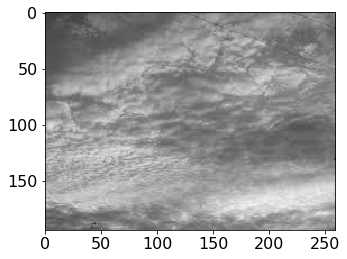

In [448]:
plt.imshow(a)

In [434]:
first_img = imageio.imread(top_first.iloc[0]['path'])

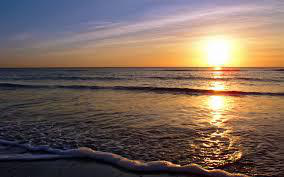

In [435]:
display(Image.open(top_first.iloc[0]['path']))

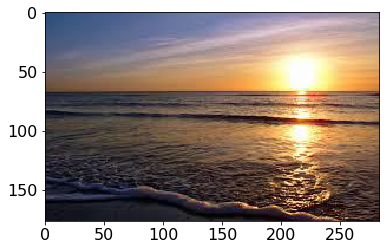

In [436]:
plt.imshow(first_img)

In [437]:
def display_image(image):
    from IPython.display import display
    
    display(Image.open(BytesIO(image._image_data)))

In [438]:
def display_images(image_paths):
    from IPython.display import display
    
    for image_path in image_paths:
        display(Image.open(image_path))
        

In [439]:
def save_images(images, prefix):
    for i, image in enumerate(images):
        Image.open(image).save(prefix % i)

Component 0
735     images/sunsets/ANd9GcRtzO5SYtgYtDyk8Uib5Bws0rR...
752     images/sunsets/ANd9GcQWa02JP_-LQNysjkhufzln-sL...
1003    images/sunsets/ANd9GcRuO3b4nk6LV75AvziyCBXB0ky...
1005    images/sunsets/ANd9GcQytuYFuMEGWjl8q2dBNlfxecB...
742     images/sunsets/ANd9GcQDNJchDVh5pfEMu0TT8RCOIJx...
162     images/cloudy_sky/ANd9GcQouo2VICwSfdtLYfPudCwP...
870     images/sunsets/ANd9GcQtEAQ5WEY6aiaaPCPHFZk4z0N...
145     images/cloudy_sky/ANd9GcSqKJsMLusKrmSOXfj6hBdw...
739     images/sunsets/ANd9GcTk_Y-Gwpbse6DT0TDV4dYWLZa...
887     images/sunsets/ANd9GcQV2VuOnacUOwUZ8vqvSL4uaLL...
Name: path, dtype: object


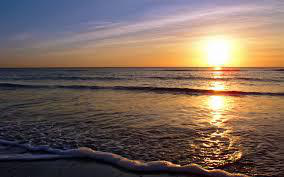

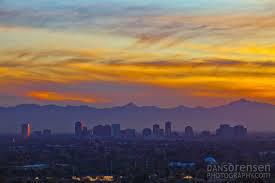

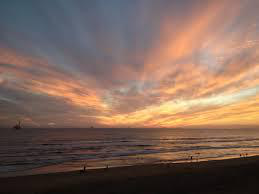

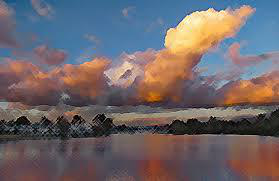

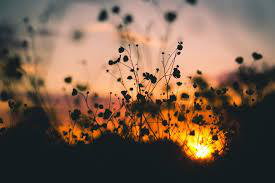

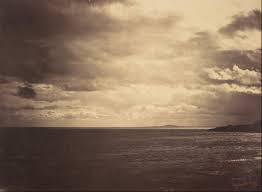

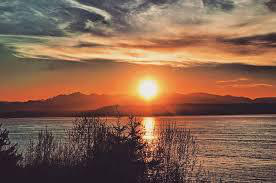

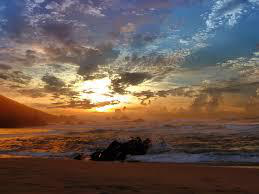

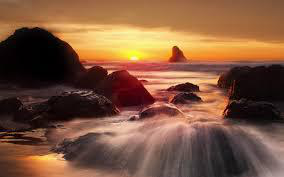

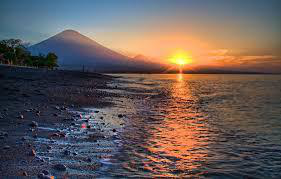



Component 1
740     images/sunsets/ANd9GcTZ37HB-ZC2mc1ak1zNwDu0uC6...
874     images/sunsets/ANd9GcTd95IegG1WaYvWsZtF0YpWaAu...
906     images/sunsets/ANd9GcRGhufKgBZb9mFZR-FAd6CHm4T...
893     images/sunsets/ANd9GcS0mhJ2Dmcy5XxDnGRrh9QkrxB...
1137    images/trees_and_forest/ANd9GcTtCyhhJuVSf_54aE...
882     images/sunsets/ANd9GcRZ6t5IILMj0_bEoTaT8TOnR-0...
973     images/sunsets/ANd9GcSCz63LbtV5fpCyJAlVplpRGn8...
727     images/sunsets/ANd9GcSAcmPvwZA4Di8dVW3QN6u0CmH...
745     images/sunsets/ANd9GcR7b1E00mp4hxZ-ytqFSUHhDPf...
769     images/sunsets/ANd9GcRQgpJHwlt5gbz8BH68oPoNxhV...
Name: path, dtype: object


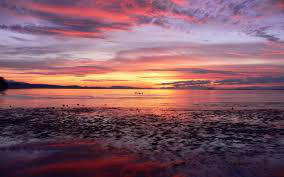

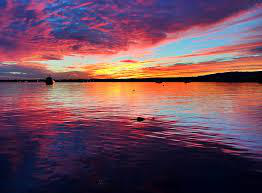

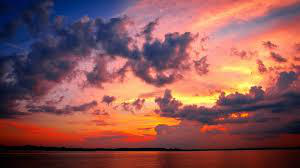

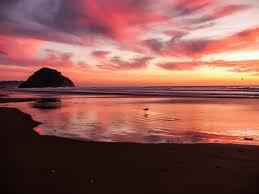

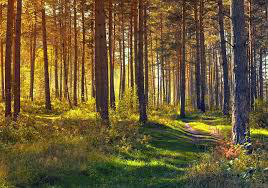

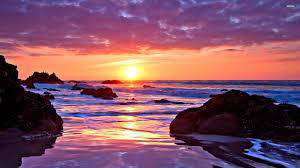

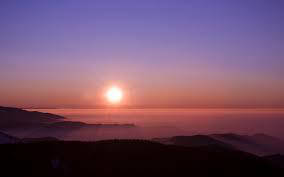

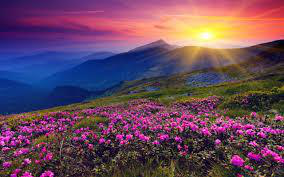

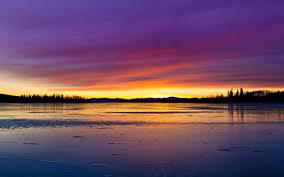

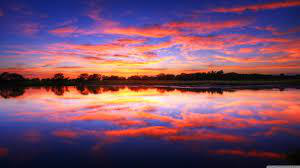



Component 2
535     images/rivers/ANd9GcThHh1geCkK2rkZcTehR877fth_...
422     images/rivers/ANd9GcTrr2h2GgteDZGKVP4T5Qa9bPJ6...
1216    images/trees_and_forest/ANd9GcRHVHvmMxZT82zcHI...
568     images/rivers/ANd9GcRetEFfEBk9l66ncFP5wRTocK7O...
292     images/rivers/ANd9GcQ3whYfUGrHELoCiurYMmOps_dN...
580     images/rivers/ANd9GcRK60zs63HEp4FdoYxIx6mp-Apb...
402     images/rivers/ANd9GcR0VcQuJwGzndY5vEXZRocuzdW-...
1071    images/trees_and_forest/ANd9GcQoyVwycL-7X1y0rw...
571     images/rivers/ANd9GcTrfOSUz5VzN_Iv1ZEoxrnJ_TNx...
1191    images/trees_and_forest/ANd9GcTw2Te9eTAT0j95vc...
Name: path, dtype: object


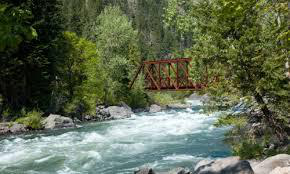

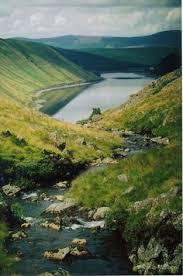

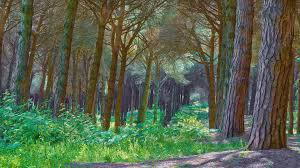

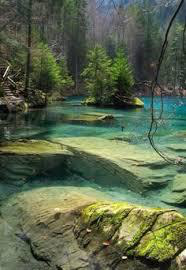

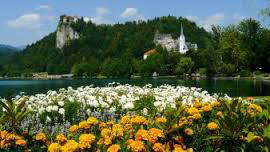

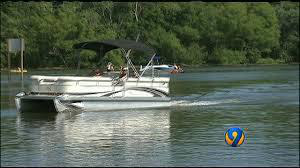

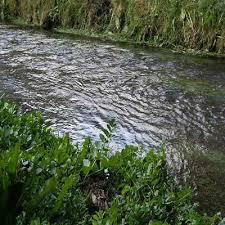

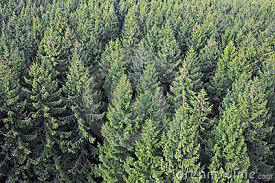

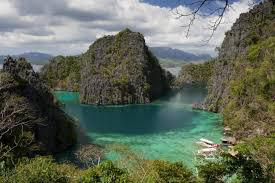

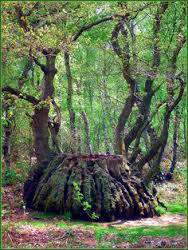



Component 3
453    images/rivers/ANd9GcSD8ZJ1D8_FnSrQjAVe-YfvJNlc...
764    images/sunsets/ANd9GcQ9Be07dZXIkJDxc3gxs--0y1l...
6      images/cloudy_sky/ANd9GcQ1D4YUCLe5MCG4xd5iNJGh...
405    images/rivers/ANd9GcQYJei-mpS8JRZTpEkj5HBB8pdS...
202    images/cloudy_sky/ANd9GcT5ijDC2wC4WYghc1HKr4AG...
183    images/cloudy_sky/ANd9GcRAW9Y2ZRUvbKqc1QKy1YBq...
384    images/rivers/ANd9GcTDJP7O0DswEDcK3bvB794CWEa3...
611    images/rivers/ANd9GcQPvoPaOHF02HBVeafeQPeMdqzU...
60     images/cloudy_sky/ANd9GcSYDlAfzXXON-s8pHk9C2nx...
284    images/cloudy_sky/ANd9GcSMZ0InIDnY_sShCi5n9mSA...
Name: path, dtype: object


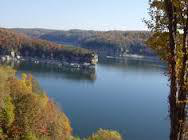

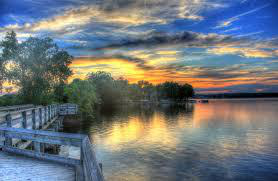

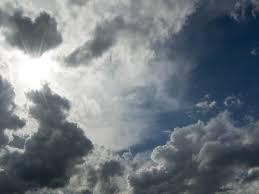

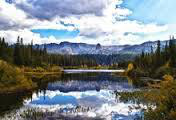

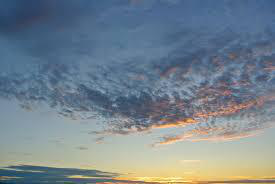

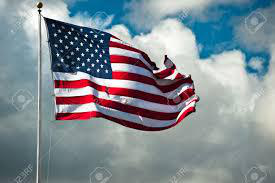

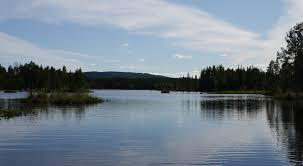

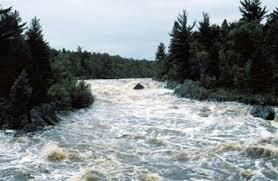

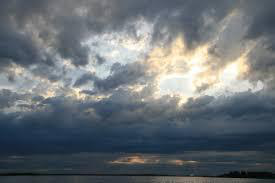

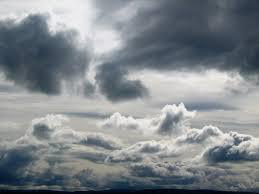

In [440]:
for component_id in range(4):
    print ('Component {0:d}'.format(component_id))
    image_paths = get_top_images(assignments, component_id,k=10)['path']
    
    print (image_paths)
    display_images(image_paths)
    
    print('\n')